# popclass example workflow

This notebook is meant to be a way to field-test `popclass`.
Treat this as an interactable sandbox/tutorial to test on real data.
The workflow herein shoud provide a sufficient baseline for `popclass` usage.

In [1]:
# imports
import numpy as np
import pandas as pd
from popclass.model import PopulationModel
from popclass.posterior import Posterior, InferenceData
from popclass.visualization import plot_population_model
from popclass.classify import classify
import matplotlib.pyplot as plt
from scipy.stats import norm

## Data

This example uses data from [Golovich et al. (2022)](https://iopscience.iop.org/article/10.3847/1538-4365/ac5969#https://gdo-microlensing.llnl.gov/).

Example data is included in `popclass/docs/source/examples/data/` within this parent directory.

In [2]:
data_path = "popclass/docs/source/examples/data/"
example_posterior = pd.read_csv(data_path)
example_posterior['log10tE'] = np.log10(example_posterior['tE'])
example_posterior['log10piE'] = np.log10(example_posterior['piE'])

##  Creating `popclass` Objects

To run the classifier, the user must create several objects that `popclass` understands:
1) A `Posterior` object that contains the set of posterior samples and parameter labels
2) An `InferenceData` object that includes the marginal of the parameters we may want for classification and associated prior density
3) A `PopulationModel` object

For this example, we are interested in classifiying in $\log_{10} t_E - \log_{10} \pi_E$ space.
We will first create a `Posterior` with the ful dataset, then a marginal over `log10tE` and `log10piE`. 

In [3]:
labels = ["log10tE", "log10piE"]

post = Posterior(
    samples=example_posterior.values,
    parameter_labels=example_posterior.columns
)

Our marginal looks like: {{marginal}}.
If we want to use this for classification, we need to specify a prior density.
In this case, we are reusing the posterior samples from [Golovich et. al. 2022](https://arxiv.org/abs/2009.07927), where the prior for $ \log_{10} t_E$ and $\log_{10} \pi_E$ was 

$$ 
p(\log_{10} t_E, \log_{10} \pi_E ) = \mathcal{N} ( \mu_{\log_{10} t_E} =1.13435 , \sigma_{\log_{10} t_E}= 0.67502)\times  \mathcal{N} ( \mu_{\log_{10} \pi_E} = -0.884205, \sigma_{\log_{10} \pi_E}= 0.5394626957)
$$

In [4]:
def golovich_prior_pdf(log10tE,log10piE):
    mulog10tE, sigmalog10tE = 1.13435, 0.33751*2 
    mulog10piE, sigmalog10piE = -0.884205, 2*np.sqrt(0.072755)
    return norm.pdf(log10tE,loc=mulog10tE,scale=sigmalog10tE)*norm.pdf(log10piE,loc=mulog10piE,scale=sigmalog10piE)


In [5]:
log10piE_samples = post.marginal(['log10piE']).samples
log10tE_samples = post.marginal(['log10tE']).samples
prior_density = golovich_prior_pdf(
        log10tE_samples,
        log10piE_samples
    )

Create an `InferenceData` object.

In [6]:
inference_data = post.to_inference_data(
    prior_density=prior_density
)

The last ingredient for classification is the `PopulationModel`.
For this, we will use one of the models included in the library/

In [7]:
population_model = PopulationModel.from_library(
    "popsycle_singles_sukhboldn20"
)

We can also visualize the population model by using visualization tools included in the library.

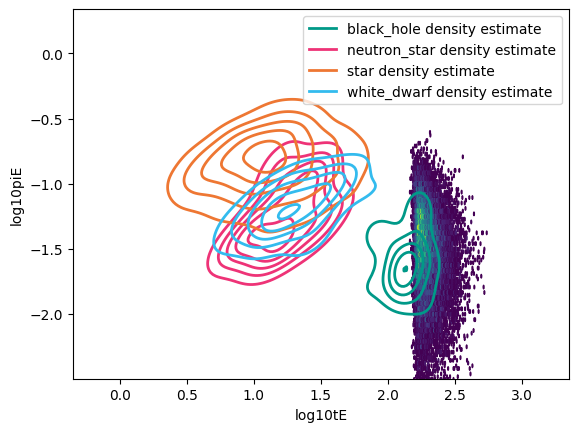

In [8]:
fig, ax = plot_population_model(
    PopulationModel=population_model,
    parameters=labels,
    levels=5,
    legend=True
)
log10piE_samples = post.marginal(['log10piE']).samples
log10tE_samples = post.marginal(['log10tE']).samples
ax.hexbin(log10tE_samples,log10piE_samples,mincnt=1)
plt.show()

## Running the classifier

With all of the ingredients in place, running the classifier is straightforward.
The output of the classifier is a dictionary containing `{classname: probability}` for each class.

In [9]:
classify(
    inference_data=inference_data,
    population_model=population_model,
    parameters=labels
)

{'black_hole': 0.901265796260476,
 'neutron_star': 8.188551956075013e-08,
 'star': 0.02635255421745685,
 'white_dwarf': 0.07238156763654754}

From the results of the classifier, our example event is *most* likely a BH.

## Changing the parameter space

To understand what features in the posterior influence the classification of an event the most, we can also rerun the classification with a different parameterization. For example, we can classify the event using only the $\log_{10} t_E$ marginal posterior, to see how the result changes. 

First we simply change the labels we are using.

In [10]:
labels=["log10tE"]

Next, we can visualize the new observational-parameter space we are using, to determine how our ability to disambiguate the different classes changes.

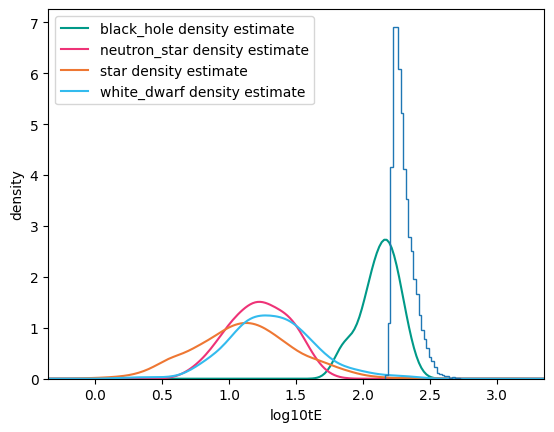

In [11]:
fig, ax = plot_population_model(
    PopulationModel=population_model,
    parameters=labels,
    levels=5,
    legend=True
)
log10piE_samples = post.marginal(['log10piE']).samples
log10tE_samples = post.marginal(['log10tE']).samples
ax.hist(log10tE_samples,bins=30,histtype='step',density=True)
plt.show()

From this plot, we can see that the separation of the classes is not as strong in this space. We might expect the result to be less informative than when we used the 2D parameter space.

In [12]:
classify(
    inference_data=inference_data,
    population_model=population_model,
    parameters=labels
)

{'black_hole': 0.5123767542883948,
 'neutron_star': 2.1810797966255555e-08,
 'star': 0.3162940172949839,
 'white_dwarf': 0.17132920660582335}

Indeed, the posterior probability of the classification of this event has shifted more to the prior, i.e., less probable to be a BH.

## Different Population Model

The underlying galactic model is another layer of uncertainty that we might want to assess.
How will our inference change when conditioned on a different galactic model? 
First, we'll go back to our original parameter space.

In [13]:
labels = ["log10tE", "log10piE"]


Next, we can load in a different model from our library, this time using a simulation based on the Spera15 IFMR. 

In [14]:
population_model = PopulationModel.from_library(
    "popsycle_singles_spera15"
)


Now, we can visualize how the predictions for each class changes with the new galactic model.

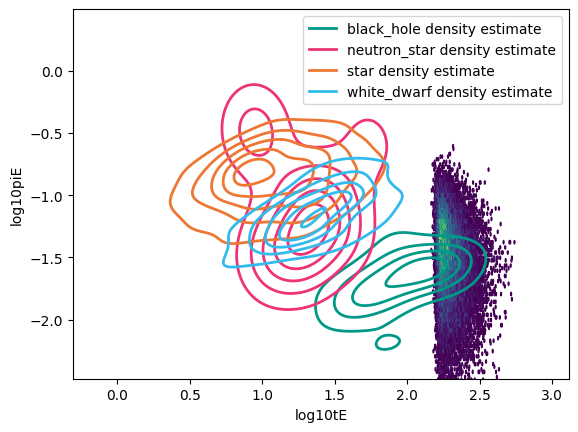

In [15]:
fig, ax = plot_population_model(
    PopulationModel=population_model,
    parameters=labels,
    levels=5,
    legend=True
)
log10piE_samples = post.marginal(['log10piE']).samples
log10tE_samples = post.marginal(['log10tE']).samples
ax.hexbin(log10tE_samples,log10piE_samples,mincnt=1)
plt.show()

We now repeat the classification procedure:

In [16]:
classify(
    inference_data=inference_data,
    population_model=population_model,
    parameters=labels
)

{'black_hole': 0.7837671765036941,
 'neutron_star': 0.00014077454663049594,
 'star': 0.08905031411032974,
 'white_dwarf': 0.12704173483934558}

We can see that while the probabilities did shift, this event seems to be robustly a high confidence BH candidate, at least when considering the population model space spanned by these two example models. 